In [1]:
import sys
sys.path.append("..")
sys.path.append("../ADsurf")
sys.path.append("../ADsurf/_cps")
from ADsurf._ADsurf import *

data_path = "./data/02_FRIUL7W/"
model = Model()

## 1. Model parameter

In [2]:
dc   = 0.005
vmin = 0.5
vmax = 5.0
tmin = 1/20
tmax = 5
layering_method   = ""
initialize_method = "Brocher"
layering_ratio    = 1.2
depth_factor      = 2
layer_number      = 6
vp_vs_ratio       = 2.45
rho = 2
fundamental_range = []
model_parameter = Model_param(
            dc=dc,
            vmin=vmin,
            vmax=vmax,
            tmin=tmin,
            tmax=tmax,
            layering_method=layering_method,
            initialize_method=initialize_method,
            layering_ratio=layering_ratio,
            depth_factor=depth_factor,
            layer_number=layer_number,
            vp_vs_ratio=vp_vs_ratio,
            rho=rho,
            fundamental_range = fundamental_range
            )

## 2. inversion parameter

In [3]:
inversion_method = "VsAndThick"
wave = "rayleigh"
algorithm = "dunkin"
mode = 0
compress = True
compress_method="exp"
normalized = True
lr = 0.001
damp_vertical = 0.002
damp_horizontal = 0
iteration = 500
step_size = 250
gamma = 0.75
optimizer="Adam"

inversion_parameter = inv_param(
                inversion_method=inversion_method,
                wave=wave,
                algorithm=algorithm,
                mode=mode,
                compress=compress,
                compress_method=compress_method,
                normalized=normalized,
                lr=lr,
                damp_vertical=damp_vertical,
                damp_horizontal=damp_horizontal,
                iteration=iteration,
                step_size=step_size,
                gamma=gamma,
                optimizer=optimizer
)

## 3. Real Model and Observed Dispersion Curve

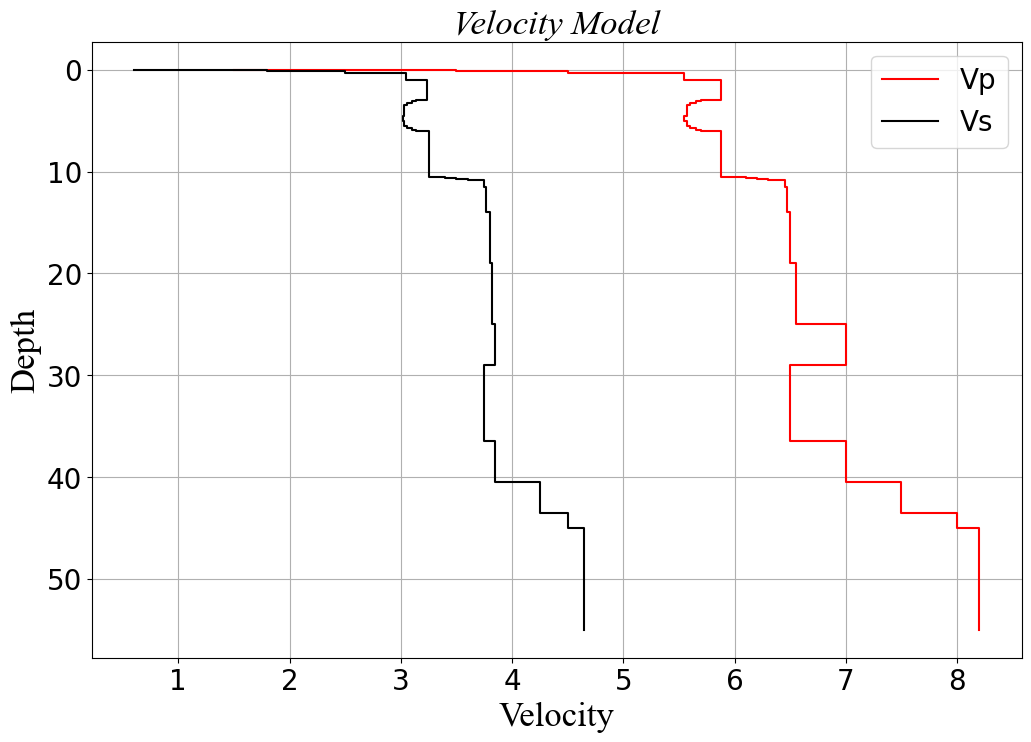

In [5]:
ADsurf_data_path = "./data/02_FRIUL7W/input/FRIUL7W-structure.txt"
FRIUL7W_model = np.loadtxt(os.path.join(ADsurf_data_path))
thick_true  = FRIUL7W_model[:,1]
rho_true    = FRIUL7W_model[:,2]
vp_true     = FRIUL7W_model[:,3]
vs_true     = FRIUL7W_model[:,5]

plot_velModel(thick=thick_true,vp=vp_true,vs=vs_true)

In [6]:
thick_true,vp_true,vs_true,rho_true = gen_model(thick_true,vs_true,area=True)
true_model = {
    "thick":thick_true.tolist(),
    "vp":vp_true.tolist(),
    "vs":vs_true.tolist(),
    "rho":rho_true.tolist(),
}
true_model = True_model(model_parameter,thick=true_model["thick"],vs=true_model["vs"],vp=true_model["vp"],rho=true_model["rho"])
model.true_model = true_model

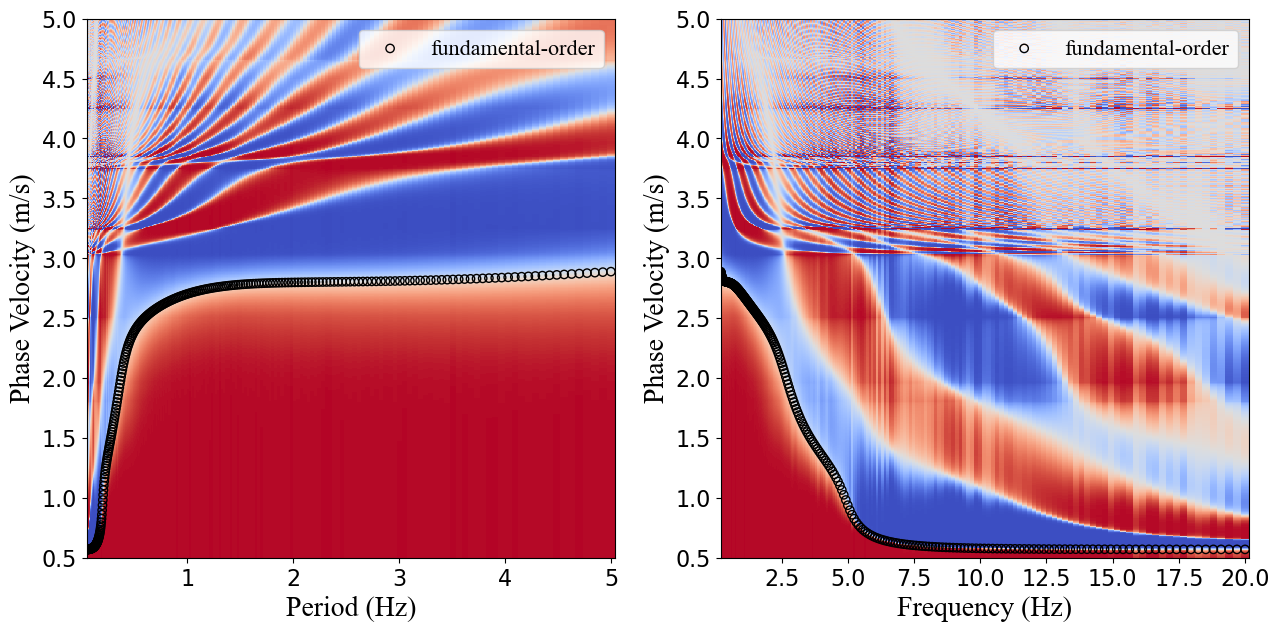

In [7]:
# calculate the determinant dipersion function
F = model.true_model._cal_determinant(sampling_method="log-wavelength",sampling_num=300)
pvs_obs = disp_obs = model.true_model._cal_dispersion_curve(sampling_method="log-wavelength",sampling_num=300,dispOrder=[0])
# post process
disp_matrix_symbol = torch.sign(F.detach())
disp_matrix = F/(torch.max(F,dim=0).values - torch.min(F,dim=0).values)
disp_matrix_compress = (1e-31)**torch.abs(disp_matrix)-1
disp_matrix_compress = disp_matrix_compress/(torch.max(disp_matrix_compress,dim=0).values - torch.min(disp_matrix_compress,dim=0).values)
disp_matrix_compress = disp_matrix_compress*disp_matrix_symbol
disp_matrix_plot = disp_matrix_compress
disp_matrix_plot[disp_matrix_plot>0] = disp_matrix_plot[disp_matrix_plot>0]/disp_matrix_plot.max()
disp_matrix_plot[disp_matrix_plot<0] = disp_matrix_plot[disp_matrix_plot<0]/np.abs(disp_matrix_plot.min())
disp_matrix_plot = disp_matrix_plot.numpy()
tlist = tensor2numpy(model.true_model.tlist)
vlist = tensor2numpy(model.true_model.vlist)

plot_param = {
    'label_font':{
                'fontsize':20,
                'color':'k',
                'family':'Times New Roman',
                'weight':'normal',
                # 'style':'italic',
                },
    'cbar_font':{
                'fontsize':16,
                'color':'k',
                'family':'Times New Roman',
                'weight':'normal',
                # 'style':'italic',
    },
    "legend_font":{
        'family': 'Times New Roman',  # 字体
        'style': 'normal',
        'size': 16,  # 字号
        'weight': "normal",  # 是否加粗，不加粗
    },
    'tick_fontsize':16,
}
plot_param = dictToObj(plot_param)

plt.figure(figsize=(15,7))
T_list,V_list_T     = np.meshgrid(tlist,vlist)
Freq_list,V_list_F  = np.meshgrid(1/tlist,vlist)
cmap="coolwarm"

plt.subplot(121)
plt.pcolormesh(T_list,V_list_T,disp_matrix_plot,cmap=cmap)
mask = pvs_obs[:,2]==0
plt.scatter(pvs_obs[:,0][mask],pvs_obs[:,1][mask],marker="o",edgecolors='black',facecolor="none",label="fundamental-order")
plt.ylim(vmin,vmax)
plt.xticks(fontsize=plot_param.tick_fontsize)
plt.yticks(fontsize=plot_param.tick_fontsize)
plt.xlabel("Period (Hz)",fontdict=plot_param.label_font)
plt.ylabel("Phase Velocity (m/s)",fontdict=plot_param.label_font)
plt.legend(loc='upper right',prop=plot_param.legend_font,frameon=True)

plt.subplot(122)
plt.pcolormesh(Freq_list,V_list_F,disp_matrix_plot,cmap=cmap)
mask = pvs_obs[:,2]==0
plt.scatter(1/pvs_obs[:,0][mask],pvs_obs[:,1][mask],marker="o",edgecolors='black',facecolor="none",label="fundamental-order")
plt.ylim(vmin,vmax)
plt.xticks(fontsize=plot_param.tick_fontsize)
plt.yticks(fontsize=plot_param.tick_fontsize)
plt.xlabel("Frequency (Hz)",fontdict=plot_param.label_font)
plt.ylabel("Phase Velocity (m/s)",fontdict=plot_param.label_font)
plt.legend(loc='upper right',prop=plot_param.legend_font,frameon=True)
plt.savefig(os.path.join(data_path,"input/observed_data.png"),bbox_inches='tight',dpi=300)
plt.show()

## 4. ADsurf 敏感核计算

In [8]:
d = numpy2tensor(thick_true)
d.requires_grad = True
a = numpy2tensor(vp_true)
a.requires_grad = True
b = numpy2tensor(vs_true)
b.requires_grad = True
rho = numpy2tensor(rho_true)
rho.requires_grad = True
vlist = numpy2tensor(pvs_obs[:,1])
vlist.requires_grad = True
tlist =numpy2tensor(pvs_obs[:,0])
# Check for water layer
llw = 0 if b[0] <= 0.0 else -1
wave = "rayleigh"
algorithm = "dunkin"
ifunc = ifunc_list[algorithm][wave] # releigh-wave dunkin's matirix
itype = 0
mode = 0

In [9]:
########################### Calculation ##################################
F = surf_vector.dltar_vector(vlist,tlist, d,a, b,rho, ifunc, llw)
# F = surf_matrix.dltar_matrix(vlist,tlist, d,a, b,rho, ifunc, llw)
F.shape

torch.Size([300])

In [10]:
import torch 
from torch import autograd

grad_a = autograd.grad(F,a,
            grad_outputs=(torch.eye(torch.numel(F)),),
            create_graph=False,
            retain_graph = True,
            is_grads_batched=True
            )[0].detach()
grad_b = autograd.grad(F,b,
            grad_outputs=(torch.eye(torch.numel(F)),),
            create_graph=False,
            retain_graph = True,
            is_grads_batched=True
            )[0].detach()
grad_d = autograd.grad(F,d,
            grad_outputs=(torch.eye(torch.numel(F)),),
            create_graph=False,
            retain_graph = True,
            is_grads_batched=True
            )[0].detach()
grad_rho = autograd.grad(F,rho,
            grad_outputs=(torch.eye(torch.numel(F)),),
            create_graph=False,
            retain_graph = True,
            is_grads_batched=True
            )[0].detach()
grad_c = autograd.grad(F,vlist,
            grad_outputs=(torch.eye(torch.numel(F)),),
            create_graph=False,
            retain_graph = True,
            is_grads_batched=True
            )[0].detach()

grad_ac_all   = -tensor2numpy(grad_a)/np.diagonal(tensor2numpy(grad_c)).reshape(-1,1)
grad_bc_all   = -tensor2numpy(grad_b)/np.diagonal(tensor2numpy(grad_c)).reshape(-1,1)
grad_dc_all   = -tensor2numpy(grad_d)/np.diagonal(tensor2numpy(grad_c)).reshape(-1,1)
grad_rhoc_all = -tensor2numpy(grad_rho)/np.diagonal(tensor2numpy(grad_c)).reshape(-1,1)

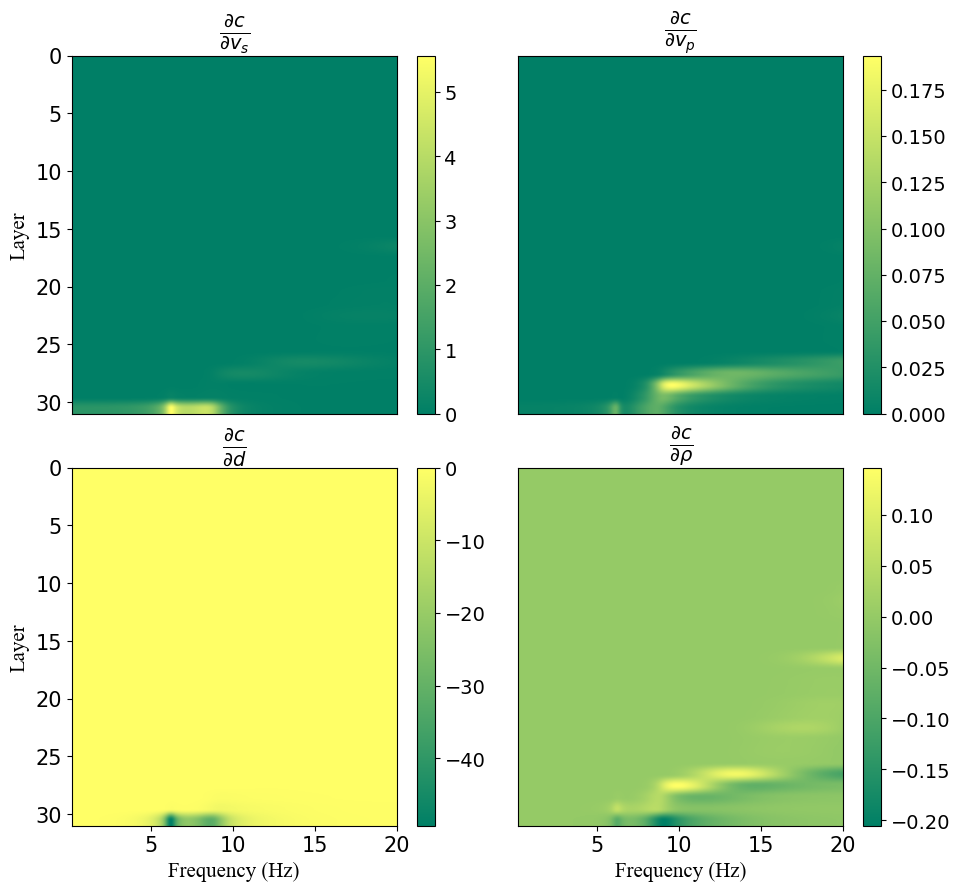

In [11]:
plot_param = {
    'title_font':{
                'fontsize':20,
                'color':'k',
                'family':'Times New Roman',
                'weight':'normal',
                # 'style':'italic',
                },
    'label_font':{
                'fontsize':15,
                'color':'k',
                'family':'Times New Roman',
                'weight':'normal',
                # 'style':'italic',
                },
    'ticks_fontsize':15,
}
plot_param = dictToObj(plot_param)

plt.figure(figsize=(11,10))

extent = [1/tmax,1/tmin,0,thick_true.shape[0]]
plt.subplot(221)
# plt.contourf(X,Y,grad_bc_all.T)
plt.imshow(grad_bc_all.T,aspect="auto",cmap="summer",extent=extent)
plt.gca().invert_yaxis()
plt.title(r"$\frac{\partial{c}}{\partial{v_s}}$",fontdict=plot_param.title_font)
plt.xticks([])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
# plt.xlabel("Frequency (Hz)",fontdict=plot_param.label_font)
plt.ylabel("Layer",fontdict=plot_param.label_font)
plt.tick_params(labelsize=plot_param.ticks_fontsize)

plt.subplot(222)
# plt.contourf(X,Y,grad_ac_all.T)
plt.imshow(grad_ac_all.T,aspect="auto",cmap="summer",extent=extent)
plt.gca().invert_yaxis()
plt.title(r"$\frac{\partial{c}}{\partial{v_p}}$",fontdict=plot_param.title_font)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
# plt.xlabel("Frequency (Hz)",fontdict=plot_param.label_font)
# plt.ylabel("Layer",fontdict=plot_param.label_font)
plt.tick_params(labelsize=plot_param.ticks_fontsize)

plt.subplot(223)
# plt.contourf(X,Y,grad_dc_all.T)
plt.imshow(grad_dc_all.T,aspect="auto",cmap="summer",extent=extent)
plt.gca().invert_yaxis()
plt.title(r"$\frac{\partial{c}}{\partial{d}}$",fontdict=plot_param.title_font)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.xlabel("Frequency (Hz)",fontdict=plot_param.label_font)
plt.ylabel("Layer",fontdict=plot_param.label_font)
plt.tick_params(labelsize=plot_param.ticks_fontsize)

plt.subplot(224)
# plt.contourf(X,Y,grad_rhoc_all.T)
plt.imshow(grad_rhoc_all.T,aspect="auto",cmap="summer",extent=extent)
plt.gca().invert_yaxis()
plt.title(r"$\frac{\partial{c}}{\partial{\rho}}$",fontdict=plot_param.title_font)
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.xlabel("Frequency (Hz)",fontdict=plot_param.label_font)
# plt.ylabel("Layer",fontdict=plot_param.label_font)
plt.tick_params(labelsize=plot_param.ticks_fontsize)
plt.subplots_adjust(hspace = 0.15,wspace=0.1)
plt.savefig(os.path.join(data_path,"sensitivity_kernel.png"),bbox_inches='tight',dpi=200)
plt.show()

> Phase velocity is more sensitive to secondary wave speed（S wave） and layer thickness（thick） and less sensitive to Primary wave speed（P wave） and density（rho）